In [7]:
from unet_zf import ZF_UNET_224
from keras.optimizers import Adam
from keras.layers import Conv2D
from keras.layers.core import Activation
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping, LambdaCallback,ModelCheckpoint, CSVLogger
import numpy as np

#own py
import streaming_unet_data
from utility_methods import collect_and_separate_labels, collect_labels,save_plots, save_plots_callback

In [8]:


model = ZF_UNET_224(weights='generator')
optim = Adam()
model.compile(optimizer=optim, loss='mse', metrics=['accuracy'])

In [9]:
model.summary()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.summary()

conv_out = Conv2D(2, (1, 1), padding='same')(model.layers[-1].output)
o = Activation('tanh', name='loss')(conv_out)

model2 = Model(input=model.input, output=[o])
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


In [10]:
model2.save('starting_unet.h5')

In [11]:
model_folder = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/20181203_unet/unet_weights.hdf5'
model2 = load_model('starting_unet.h5')

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
for layer in model2.layers[:-7]:
    layer.trainable = False

In [49]:
image_folder = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/samples/images/'
patience=15
early_stopping=EarlyStopping(monitor='loss',patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='unet_test_weights.hdf5', monitor='loss', save_best_only=True, verbose=1)
csv_logger = CSVLogger('unet_test_training.log', append=True)

traain = streaming_unet_data.StreamingUnet_DataGenerator(image_folder,batch_size=16)

import keras.backend as K


def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

model2.compile(loss = euclidean_distance_loss, optimizer='rmsprop')

Length of image list:  28


In [50]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
history = model2.fit_generator(generator=traain,
                    validation_data=traain,
                    epochs=30,
                    callbacks=[csv_logger,checkpointer, early_stopping])

Epoch 1/30
1/1 [==============================] - 78s 78s/step - loss: 0.2903 - val_loss: 1.7968

Epoch 00001: loss improved from inf to 0.29033, saving model to unet_test_weights.hdf5
Epoch 2/30
1/1 [==============================] - 69s 69s/step - loss: 0.9076 - val_loss: 1.7940

Epoch 00002: loss did not improve from 0.29033
Epoch 3/30
1/1 [==============================] - 68s 68s/step - loss: 0.7223 - val_loss: 1.1137

Epoch 00003: loss did not improve from 0.29033
Epoch 4/30
1/1 [==============================] - 71s 71s/step - loss: 0.5676 - val_loss: 1.5788

Epoch 00004: loss did not improve from 0.29033
Epoch 5/30
1/1 [==============================] - 72s 72s/step - loss: 0.6796 - val_loss: 1.1836

Epoch 00005: loss did not improve from 0.29033
Epoch 6/30
1/1 [==============================] - 62s 62s/step - loss: 0.5023 - val_loss: 1.6017

Epoch 00006: loss did not improve from 0.29033
Epoch 7/30
1/1 [==============================] - 61s 61s/step - loss: 0.4782 - val_loss: 

KeyboardInterrupt: 

Length of image list:  28
XMAX 254.9670559630107


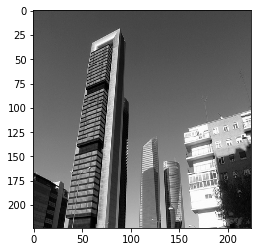

float64
-1.0
1.0
-1.0
1.0
min r:  0.0
max r:  1.0
min g:  0.0
max g:  1.0
min b:  0.0
max b:  1.0


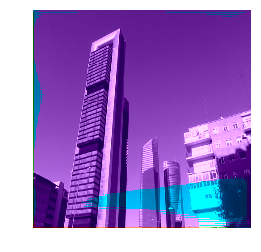

XMAX 254.96898804209172


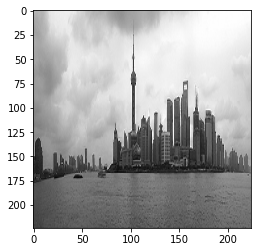

float64
-1.0
1.0
-1.0
1.0
min r:  0.0
max r:  1.0
min g:  0.0
max g:  1.0
min b:  0.0
max b:  1.0


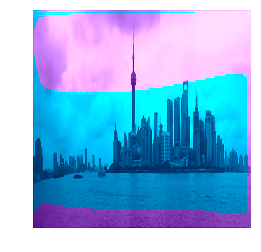

XMAX 254.6946532605229


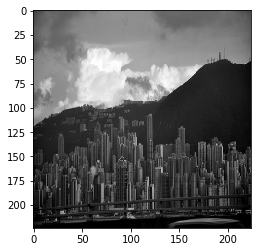

float64
-1.0
1.0
-1.0
1.0
min r:  0.0
max r:  1.0
min g:  0.0
max g:  1.0
min b:  0.0
max b:  1.0


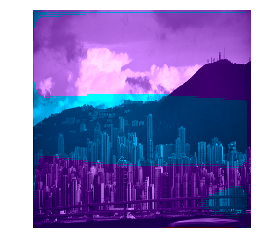

XMAX 245.21319309430763


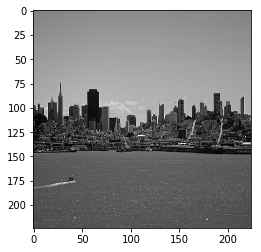

float64
-1.0
1.0
-1.0
1.0
min r:  0.0
max r:  1.0
min g:  0.0
max g:  1.0
min b:  0.0
max b:  1.0


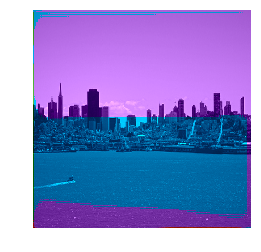

XMAX 250.92511895727026


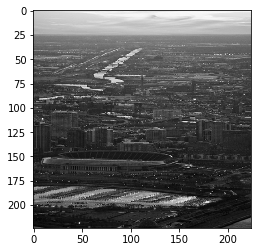

float64
-1.0
1.0
-1.0
1.0
min r:  0.0
max r:  1.0
min g:  0.0
max g:  1.0
min b:  0.0
max b:  1.0


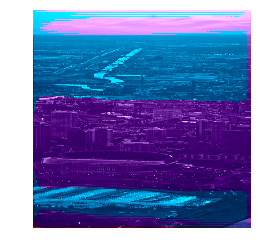

XMAX 254.60430795400197


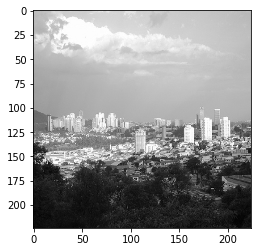

float64
-1.0
1.0
-1.0
1.0
min r:  0.0
max r:  1.0
min g:  0.0
max g:  1.0
min b:  0.0
max b:  1.0


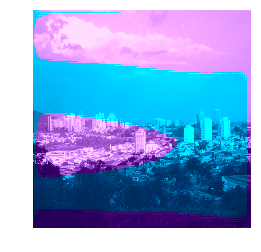

XMAX 254.04293728475778


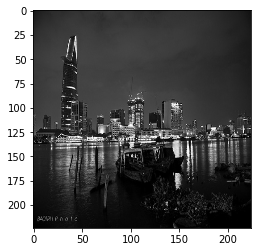

float64
-1.0
1.0
-1.0
1.0
min r:  0.0
max r:  1.0
min g:  0.0
max g:  0.8721366445257761
min b:  0.0
max b:  1.0


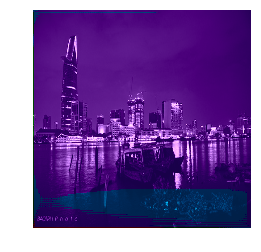

XMAX 235.8800402762275


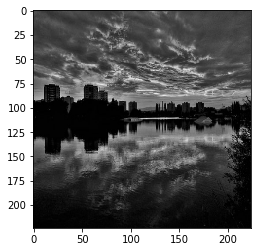

float64
-1.0
1.0
-1.0
1.0
min r:  0.0
max r:  1.0
min g:  0.0
max g:  0.7906504159481369
min b:  0.0
max b:  1.0


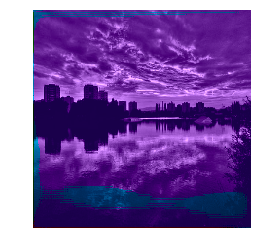

XMAX 254.94155673828107


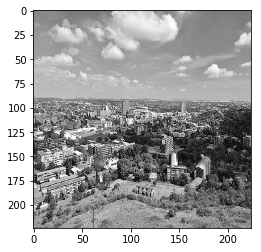

float64
-1.0
1.0
-1.0
1.0
min r:  0.0
max r:  1.0
min g:  0.0
max g:  1.0
min b:  0.0
max b:  1.0


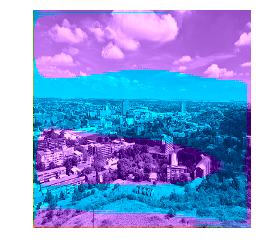

XMAX 192.84483541334652


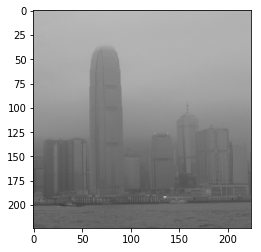

float64
-1.0
1.0
-1.0
1.0
min r:  0.0
max r:  0.8850415800682012
min g:  0.0630432859092683
max g:  0.8394691936497664
min b:  0.0
max b:  1.0


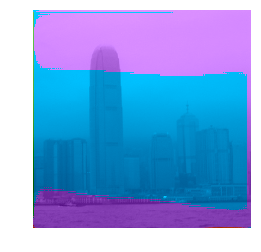

XMAX 234.22499283521998


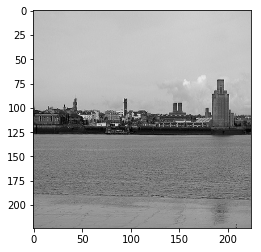

float64


KeyboardInterrupt: 

In [51]:
from matplotlib.pyplot import imshow
from skimage import color
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import transform, io, color

from importlib import reload  # Python 3.4+ only.
streaming_data = reload(streaming_unet_data)

root_pictures = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/20181203_unet/test_pics/'
watcher = streaming_unet_data.StreamingUnet_DataGenerator(image_folder,batch_size=1, random_trf= False)

for idx in range(len(watcher)):
    X,Y = watcher[idx]
    print('XMAX', np.max(X))
    plt.imshow(watcher.gray_img[0]/255)
    plt.show()
    print(Y.dtype)
    rgb_img = conc_pred(model2, X, watcher)
    plt.imshow(rgb_img)
    plt.axis('off')
    plt.savefig(root_pictures + 'test_img'+str(idx)+'.png', bbox_inches='tight')
    plt.show()

In [41]:
def conc_pred(model, X, watcher, Y = None):
    y_real = model.predict(X)[0]
    if (Y is not None):
        y_real = Y
    y_real = y_real.astype(np.float64)
    y_real = np.clip(y_real,-1,1)
    print(np.min(y_real[:,:,0] ))
    print(np.max(y_real[:,:,0] ))
    print(np.min(y_real[:,:,1] ))
    print(np.max(y_real[:,:,1] ))
    y_real[:,:,0] = (y_real[:,:,0]) * 50
    y_real[:,:,1] = (y_real[:,:,1]) * 50
    
    lab_im = np.concatenate([X[0,:,:,0, np.newaxis]/255*100,y_real[:,:,0, np.newaxis], y_real[:,:,1, np.newaxis]], axis = 2)
    rgb_img = color.lab2rgb(lab_im)
    print('min r: ',np.min(rgb_img[:,:,0]))
    print('max r: ',np.max(rgb_img[:,:,0]))
    print('min g: ',np.min(rgb_img[:,:,1]))
    print('max g: ',np.max(rgb_img[:,:,1]))
    print('min b: ',np.min(rgb_img[:,:,2]))
    print('max b: ',np.max(rgb_img[:,:,2]))
    
    return rgb_img